In [ ]:
import torch
import torch.nn.functional as f
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torchsummary import summary
import psutil

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print(f'vCPUs:{psutil.cpu_count()}')

Your runtime has 13.7 gigabytes of available RAM

vCPUs:2


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('No GPU')
else:
    print(gpu_info)

Fri Aug 21 19:13:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Train data transformation

train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                                       ])
                                       

# Test transform

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                                      ])

Dataset and creating Train/Test split

In [ ]:
train = datasets.MNIST(root='../data', train=True, download=True, transform=train_transforms)

test = datasets.MNIST(root='../data', train=False, download=True, transform=test_transforms)

Dataloader arguments and train test dataloaders

In [ ]:
torch.manual_seed(100)

In [ ]:
cuda = torch.cuda.is_available()

if cuda:
  print('\n CUDA is available')
  torch.cuda.manual_seed(100)
else:
  print("\n No GPU")

  


 CUDA is available


In [ ]:
WORKERS = 2
BATCH_SIZE = 64

In [ ]:
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=WORKERS, pin_memory=True) if cuda\
 else dict(shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
# train dataloader 

train_loader = torch.utils.data.DataLoader(dataset=train, **dataloader_args)


# test dataloader

test_loader = torch.utils.data.DataLoader(dataset=test, **dataloader_args)

In [ ]:
train_data = train.train_data # type == torch.Tensor

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
train_data = train.transform(train_data.numpy()) # torch.Tensor(indirectly). Does .transform() refers to the steps in transform of train defined earlier ?

In [ ]:
type(train_data)

torch.Tensor

In [ ]:
train_data.numpy().shape

(28, 60000, 28)

In [ ]:
train_data.to('cpu').numpy().shape

(28, 60000, 28)

In [ ]:
torch.min(train_data)

tensor(-0.4242)

In [ ]:
torch.max(train_data)

tensor(2.8215)

In [ ]:
torch.mean(train_data)

tensor(-0.0002)

In [ ]:
torch.std(train_data)

tensor(1.0000)

In [ ]:
torch.var(train_data)

tensor(1.0001)

In [ ]:
# data_iter = iter(train_data)

In [ ]:
# next(data_iter)

In [ ]:
dataiter = iter(train_loader)

In [ ]:
images, labels = next(dataiter)

In [ ]:
images.shape

torch.Size([64, 1, 28, 28])

In [ ]:
labels.shape

torch.Size([64])

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

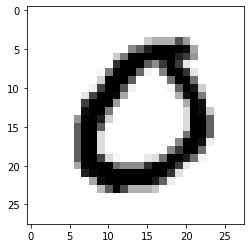

In [ ]:
plt.imshow(images[20].numpy().squeeze(), cmap='gray_r')

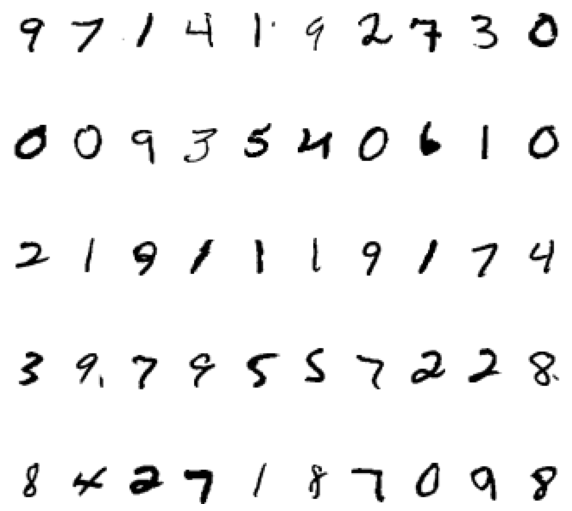

In [ ]:
fig = plt.figure(figsize=(10,10))
images_num = 50
for index in range(1, images_num + 1):
    plt.subplot(5,10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

In [ ]:

def train(model, device, train_loader, optimizer, epochs=1, scheduler=None, test=False, test_loader=None, reset=None):
    if test and not test_loader:
        raise ValueError("`test`= True but `test_loader` not provided")
    if reset:
      for i in reset:
          i = []
          
    model.train()
    for epoch in range(epochs):
      correct = 0
      processed = 0
      train_loss = 0
      print(f"\n\nepoch: {epoch+1}")
      pbar = tqdm(train_loader)
      for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()
          output = model(data)
          loss = f.nll_loss(output, target)
          train_loss += loss.item()
          loss.backward()
          optimizer.step()
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()
          processed += len(data)
      acc = 100 * correct/processed
      train_losses.append(train_loss)
      train_accuracy.append(acc)
      pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
      
      if scheduler:
          print(f'lr: {scheduler.get_last_lr()[0]}')
          scheduler.step()
      
      train_loss /= len(train_loader.dataset)
      print('\nTrain set:                              Accuracy: {}/{} ({:.6f}%)'.format(correct, len(train_loader.dataset), 100.0 * correct / len(train_loader.dataset)))

      if test:
          model.eval()
          test_loss = 0
          correct = 0
          with torch.no_grad():
              for data, target in test_loader:
                  data, target = data.to(device), target.to(device)
                  output = model(data)
                  test_loss += f.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                  correct += pred.eq(target.view_as(pred)).sum().item()

          test_loss /= len(test_loader.dataset)
          test_losses.append(test_loss)
          test_accuracy.append(100. * correct / len(test_loader.dataset))

          print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
              test_loss, correct, len(test_loader.dataset),
              100. * correct / len(test_loader.dataset)))

## CODE 1

First code attempts to create a working yet very basic model with increasing number of filters but not going wild like other networks that operate on larger input images, while trying to reach maximum accuracy possible. For this model, however, the number of parameters were NOT taken into consideration. The idea here is to fix the number and position of Convolution layers. The architecture in `Code 1` is largely based upon the data set given. And subsequent codes will try to work upon this and improve further.

In [ ]:
class Net1(nn.Module):        
    def __init__(self):
        super(Net1, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=26, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24
        
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=26, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 12

        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 10

        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) 
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) 

        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x) # since it's MNIST and 1x28x28 images, 7x7 makes little sense for such small image dataset to get related features, so starting network itself contains maxpool at 5x5 RF
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return f.log_softmax(x, dim=-1)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net1().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 26, 26, 26]           3,744
              ReLU-4           [-1, 26, 26, 26]               0
         MaxPool2d-5           [-1, 26, 13, 13]               0
            Conv2d-6           [-1, 16, 13, 13]             416
              ReLU-7           [-1, 16, 13, 13]               0
            Conv2d-8           [-1, 20, 11, 11]           2,880
              ReLU-9           [-1, 20, 11, 11]               0
           Conv2d-10             [-1, 24, 9, 9]           4,320
             ReLU-11             [-1, 24, 9, 9]               0
           Conv2d-12             [-1, 32, 7, 7]           6,912
             ReLU-13             [-1, 32, 7, 7]               0
           Conv2d-14             [-1, 1

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
train(model, device, train_loader, optimizer, epochs=15, scheduler=None, test=True, test_loader=test_loader, reset = [train_losses, test_losses, train_accuracy, test_accuracy])

  0%|          | 0/938 [00:00<?, ?it/s]



epoch: 1


100%|██████████| 938/938 [00:12<00:00, 75.02it/s]


Train set:                              Accuracy: 40542/60000 (67.570000%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1446, Accuracy: 9554/10000 (95.540000%)



epoch: 2


100%|██████████| 938/938 [00:12<00:00, 74.72it/s]


Train set:                              Accuracy: 58013/60000 (96.688333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0781, Accuracy: 9741/10000 (97.410000%)



epoch: 3


100%|██████████| 938/938 [00:12<00:00, 76.60it/s]


Train set:                              Accuracy: 58691/60000 (97.818333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9837/10000 (98.370000%)



epoch: 4


100%|██████████| 938/938 [00:12<00:00, 76.23it/s]


Train set:                              Accuracy: 58942/60000 (98.236667%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9852/10000 (98.520000%)



epoch: 5


100%|██████████| 938/938 [00:12<00:00, 76.71it/s]


Train set:                              Accuracy: 59115/60000 (98.525000%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9880/10000 (98.800000%)



epoch: 6


100%|██████████| 938/938 [00:12<00:00, 76.33it/s]


Train set:                              Accuracy: 59214/60000 (98.690000%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9872/10000 (98.720000%)



epoch: 7


100%|██████████| 938/938 [00:12<00:00, 76.75it/s]


Train set:                              Accuracy: 59265/60000 (98.775000%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9876/10000 (98.760000%)



epoch: 8


100%|██████████| 938/938 [00:12<00:00, 76.83it/s]


Train set:                              Accuracy: 59369/60000 (98.948333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9876/10000 (98.760000%)



epoch: 9


100%|██████████| 938/938 [00:12<00:00, 77.03it/s]


Train set:                              Accuracy: 59430/60000 (99.050000%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9869/10000 (98.690000%)



epoch: 10


100%|██████████| 938/938 [00:12<00:00, 77.38it/s]


Train set:                              Accuracy: 59458/60000 (99.096667%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9889/10000 (98.890000%)



epoch: 11


100%|██████████| 938/938 [00:12<00:00, 77.16it/s]


Train set:                              Accuracy: 59509/60000 (99.181667%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9909/10000 (99.090000%)



epoch: 12


100%|██████████| 938/938 [00:12<00:00, 77.98it/s]


Train set:                              Accuracy: 59573/60000 (99.288333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9891/10000 (98.910000%)



epoch: 13


100%|██████████| 938/938 [00:11<00:00, 78.56it/s]


Train set:                              Accuracy: 59581/60000 (99.301667%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9910/10000 (99.100000%)



epoch: 14


100%|██████████| 938/938 [00:11<00:00, 79.39it/s]


Train set:                              Accuracy: 59615/60000 (99.358333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9878/10000 (98.780000%)



epoch: 15


100%|██████████| 938/938 [00:11<00:00, 78.52it/s]


Train set:                              Accuracy: 59623/60000 (99.371667%)



Test set: Average loss: 0.0412, Accuracy: 9884/10000 (98.840000%)



Text(0.5, 1.0, 'Test Accuracy')

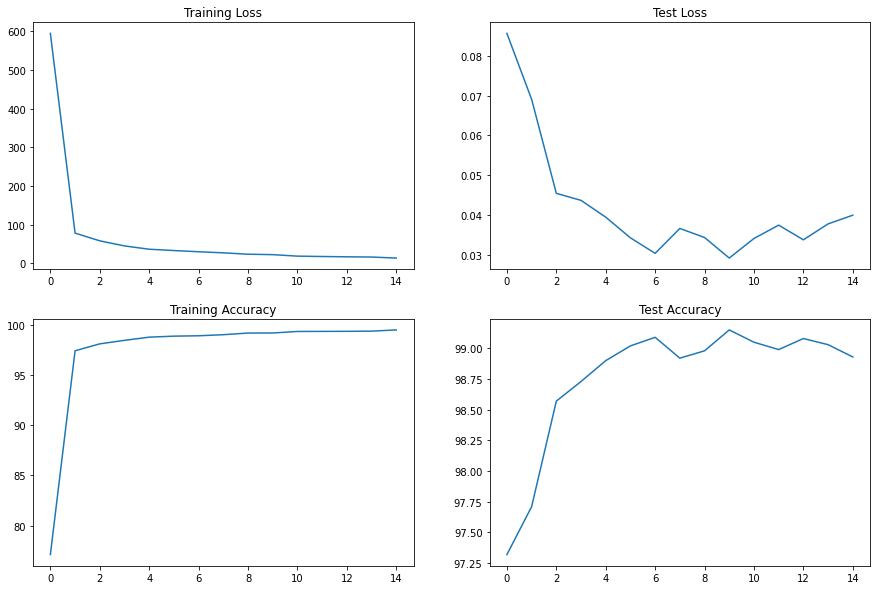

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracy)
axs[1, 1].set_title("Test Accuracy")

# Analysis

#### The architecture was built taking into consideration the small size of the input dataset.

#### However, there is clear sign of inability of the model to generalize well.

>The test set crossed 99% accuracy in the 11th epoch while the final epoch has 98.84% test accuracy whereas the train accuracy is at 99.37%. --> So some overfitting is evident.

> Despite the parameters being not huge, the model shows potential to learn.

>The train accuracy not reaching higher values: could it be lack of decision making at deeper layers due to unclear representations? 

>Are the kernel at deeper layer or layer in between not able to figure out the correct activations. Will adding Batch Normalization and Dropout help in this case? That's what I will implement in `Code 2` if accuracy ranges as result of amplitudes becoming prominent after BN and gap reduces with Dropout.....next !!